In [63]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, Dropout, Activation
from keras.models import Model
from sklearn.model_selection import train_test_split
from preprocessing2 import *

In [2]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100

In [3]:
def split_data(df, ratio, state=1):
    """
    :param ratio: test fraction
    :param state: random_state
    :return:
    """
    X = df.text
    y = df.author
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=ratio, random_state=state)
    return X_train, X_test, y_train, y_test

In [4]:
def encode_authors(labels):
    """
    :param labels: np.array or list of string authors
    :return: categorical list (for keras)
    """
    authors_vocab = {"EAP": 0, "HPL": 1, "MWS": 2}
    y = [authors_vocab[label] for label in labels]
    y = to_categorical(y, num_classes=3)
    return y

In [5]:
def encode_texts(text, embedding_vocab, embedding_size):
    emb_func = lambda sent: sentence_to_emb(sent, embedding_vocab, embedding_size)
    emb_texts = np.array([emb_func(sent) for sent in text])
    return emb_texts

In [7]:

X_train, X_test, y_train, y_test = split_data(train_df, 0.8)
X_train = X_train.apply(clean_text)
X_train = X_train.apply(lambda row: lemmatize_text(row))

X_test = X_test.apply(clean_text)
X_test = X_test.apply(lambda row: lemmatize_text(row))

In [10]:
y_train = encode_authors(y_train)
y_test = encode_authors(y_test)

In [16]:
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [18]:
train_df = create_df("train.csv")
texts = train_df.text.apply(clean_text)
texts = texts.apply(lambda row: lemmatize_text(row))

In [19]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [20]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22282 unique tokens.


In [27]:
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [33]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data, train_df.author, train_size=0.8, random_state=1)

In [40]:
y_train = encode_authors(y_train)
y_test = encode_authors(y_test)

In [44]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [103]:
batch_size = 64
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 15

In [102]:
from keras import regularizers

In [104]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)


r = LSTM(100, return_sequences=False)(embedded_sequences)
dr = Dropout(0.5)(r)
de = Dense(256, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(dr)
dr2 = Dropout(0.5)(de)
p = Dense(3, activation='sigmoid')(dr2)
"""


x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
p = Dense(3, activation='softmax')(x)
"""
"""
x = Dropout(0.2)(embedded_sequences)
x = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(x)
# we use max pooling:
x = GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = Dense(hidden_dims)(x)
x = Dropout(0.2)(x)
x = Activation('relu')(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
x = Dense(3)(x)
p = Activation('sigmoid')(x)
"""

"\nx = Dropout(0.2)(embedded_sequences)\nx = Conv1D(filters,\n                 kernel_size,\n                 padding='valid',\n                 activation='relu',\n                 strides=1)(x)\n# we use max pooling:\nx = GlobalMaxPooling1D()(x)\n\n# We add a vanilla hidden layer:\nx = Dense(hidden_dims)(x)\nx = Dropout(0.2)(x)\nx = Activation('relu')(x)\n\n# We project onto a single unit output layer, and squash it with a sigmoid:\nx = Dense(3)(x)\np = Activation('sigmoid')(x)\n"

In [105]:
model = Model(sequence_input, p)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [106]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

Train on 15663 samples, validate on 3916 samples
Epoch 1/15
15663/15663 [==============================] - 70s - loss: 1.2222 - acc: 0.5009 - val_loss: 0.9264 - val_acc: 0.6027
Epoch 2/15
15663/15663 [==============================] - 71s - loss: 0.9547 - acc: 0.5925 - val_loss: 0.9114 - val_acc: 0.6162
Epoch 3/15
15663/15663 [==============================] - 68s - loss: 0.9265 - acc: 0.6141 - val_loss: 0.8700 - val_acc: 0.6422
Epoch 4/15
15663/15663 [==============================] - 68s - loss: 0.8937 - acc: 0.6298 - val_loss: 0.8659 - val_acc: 0.6456
Epoch 5/15
15663/15663 [==============================] - 73s - loss: 0.8637 - acc: 0.6493 - val_loss: 0.8816 - val_acc: 0.6315
Epoch 6/15
15663/15663 [==============================] - 85s - loss: 0.8413 - acc: 0.6594 - val_loss: 0.8656 - val_acc: 0.6466
Epoch 7/15
15663/15663 [==============================] - 86s - loss: 0.8143 - acc: 0.6764 - val_loss: 0.8295 - val_acc: 0.6655
Epoch 8/15
15663/15663 [==============================]

In [74]:
def words2sequences(words):
    return [word2num[w]+3 if w in word2num else 2 for w in text_to_word_sequence(words)]

In [75]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25856     
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total para

In [76]:
embed = model.layers[1].get_weights()[0]
embed.shape

(20000, 100)

In [77]:
from sklearn.decomposition import PCA
embed_2d = PCA(n_components = 2).fit_transform(embed)
embed_2d.shape

(20000, 2)

In [79]:
word2num = word_index
num2word = {v: k for k, v in word2num.items()}

In [81]:
from keras.preprocessing.text import text_to_word_sequence

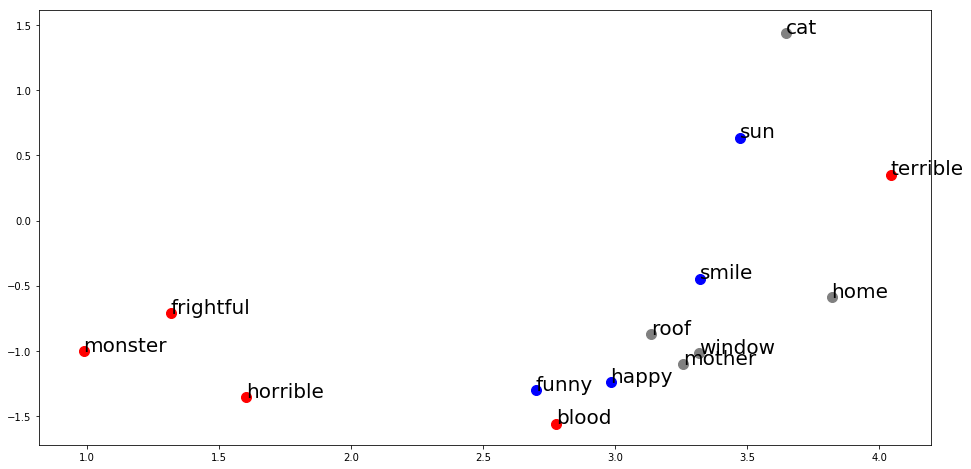

In [101]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
word_idx=[]
for word in ["blood","terrible","horrible","frightful","monster"]:
    idx = words2sequences(word)[0]
    word_idx.append(idx)
    plt.scatter(embed_2d[idx,0],embed_2d[idx,1],color="red",s=100)
    plt.text(embed_2d[idx, 0], embed_2d[idx, 1], num2word[idx- 3],fontsize=20)
for word in ["funny", "happy", "sun", "smile"]:
    idx = words2sequences(word)[0]
    word_idx.append(idx)
    plt.scatter(embed_2d[idx,0],embed_2d[idx,1],color="blue",s=100)
    plt.text(embed_2d[idx, 0], embed_2d[idx, 1], num2word[idx- 3],fontsize=20)

for word in ["home", "roof", "window","cat","mother"]:
    idx = words2sequences(word)[0]
    word_idx.append(idx)
    plt.scatter(embed_2d[idx,0],embed_2d[idx,1],color="gray",s=100)
    plt.text(embed_2d[idx, 0], embed_2d[idx, 1], num2word[idx- 3],fontsize=20)

plt.show()